# mnist
## 获取数据

In [2]:
# import library
import pandas as pd
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([5, 0, 4, ..., 4, 5, 6], dtype=int8))

## 划分训练集和测试集

In [6]:
X, y = mnist['data'], mnist['target']
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 训练二分类器 

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)


sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
# sgd_clf.fit(X_train, y_train_5)


cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96755, 0.9686 , 0.95905])

## 性能评估（precision、recall）

In [8]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.9026398643739404, 0.687511529238148)

### precision、recall tradeoff

In [10]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
y_scores[:10]

array([ -3777.83520099,  -7350.73379929,  -7424.59842915,  -7584.59844895,
        -6660.10879117, -15123.86679931, -19231.40969097,  -5781.57508513,
        11273.90035794,  -9913.85130493])

In [11]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
precisions[:10], recalls[:10], thresholds[:10]

(array([0.09040273, 0.09038757, 0.09038907, 0.09039058, 0.09039209,
        0.0903936 , 0.0903951 , 0.09039661, 0.09039812, 0.09039963]),
 array([1.        , 0.99981553, 0.99981553, 0.99981553, 0.99981553,
        0.99981553, 0.99981553, 0.99981553, 0.99981553, 0.99981553]),
 array([-86481.49391958, -86225.96816077, -86170.67425466, -86042.19880255,
        -85981.48988572, -85910.42854146, -85646.79205016, -85560.12096344,
        -84910.68398315, -84744.11548389]))

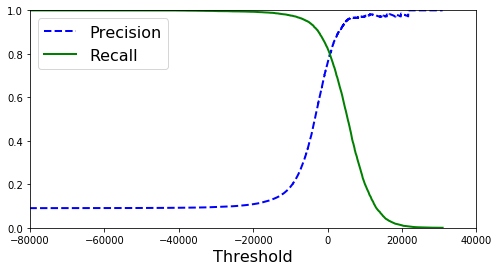

In [16]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-80000, 40000])
plt.show()

### roc curve

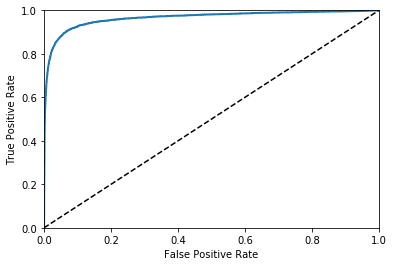

In [18]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [19]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9652772697468914

### compare RandomForestClassifier with SGDClassifier

In [24]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")



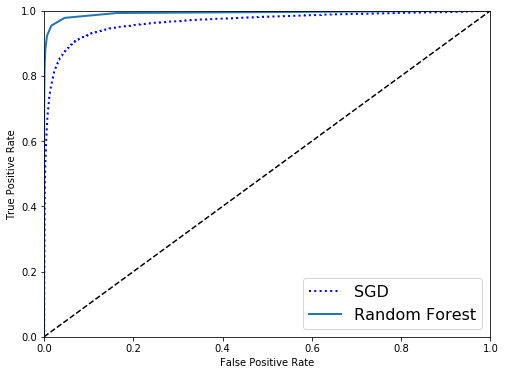

In [23]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [26]:
roc_auc_score(y_train_5, y_scores_forest)

0.9926280742864875

In [27]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred_forest)

(0.9856985698569857, 0.8264157904445675)